In [1]:
import pandas as pd

filepath1 = 'Exports/Data/7.TractMasterDataset.csv'
filepath2 ='Exports/Data/6.CountyMasterDataset.csv'

tract_data = pd.read_csv(filepath1)
county_data = pd.read_csv(filepath2)

***County Data***

1. Restricting data to people born in same state they live in

In [2]:
# Restrict data to rows where BPL == STATEFP
mask = county_data['BPL'] == county_data['STATEFP']
print(f'Share of individuals living in birth state: {mask.mean():.2%}')
county_data = county_data[mask].copy()
print('Dropped. Now all individuals live in their birth state.')

Share of individuals living in birth state: 53.34%
Dropped. Now all individuals live in their birth state.


2. Identifying initial date of Hip Hop exposure

<Axes: title={'center': 'Number of places that started playing Hip Hop in each year'}, xlabel='initial_HH_exp'>

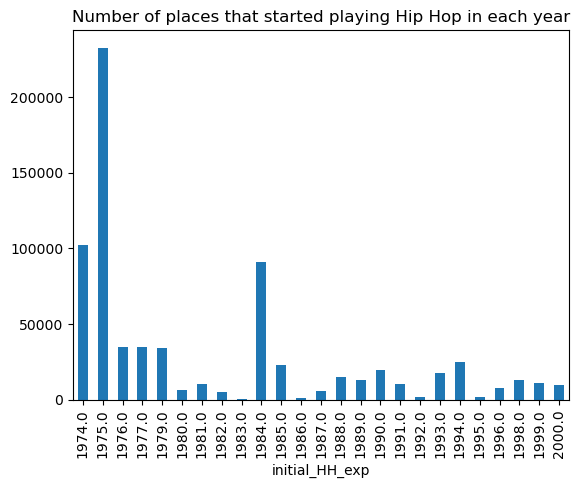

In [3]:
county_data.initial_HH_exp.value_counts().sort_index().plot(kind='bar', title='Number of places that started playing Hip Hop in each year')

In [4]:
# Let's identify places that never had Hip Hop before 1997
county_data['no_HH_before_97'] = (county_data['initial_HH_exp'] > 1998).astype(int)

assert county_data.query('no_HH_before_97 == 1').query("non_weighted_ave_HH_conc != 0").empty
assert county_data.query('non_weighted_ave_HH_conc == 0').query('non_weighted_sum_HH_conc != 0').empty
assert county_data.query('non_weighted_sum_HH_conc != 0').query('non_weighted_sum_HH_conc == 0').empty

print('There are a few counties that do not play Hip Hop in 1997, but did play Hip Hop in an earlier year')
county_data.query("non_weighted_ave_HH_conc == 0").no_HH_before_97.value_counts()

There are a few counties that do not play Hip Hop in 1997, but did play Hip Hop in an earlier year


no_HH_before_97
0    289346
1     21205
Name: count, dtype: int64

In [5]:
mask = county_data.query("non_weighted_ave_HH_conc == 0 and no_HH_before_97 == 1").index
county_data.drop(mask, inplace=True)
assert county_data.query('no_HH_before_97 == 1').query("non_weighted_ave_HH_conc != 0").empty
print('Dropped. Now all places with no HH in 1997 never had HH before 1997')
county_data.drop(columns=['no_HH_before_97'], inplace=True)

Dropped. Now all places with no HH in 1997 never had HH before 1997


3. Keeping places exposed to HH within 10 years of 1997

In [6]:
print("I will sample to places exposed to HH_exp within 10 years of 1997")
mask = (county_data['initial_HH_exp'] - 1997).abs() <= 10
county_data = county_data[mask].copy()
print('Dropped. Now all places were exposed to Hip Hop within 10 years of 1997')

I will sample to places exposed to HH_exp within 10 years of 1997
Dropped. Now all places were exposed to Hip Hop within 10 years of 1997


4. Calculating Age at Initial Exposure

<Axes: xlabel='age_at_initial_exp'>

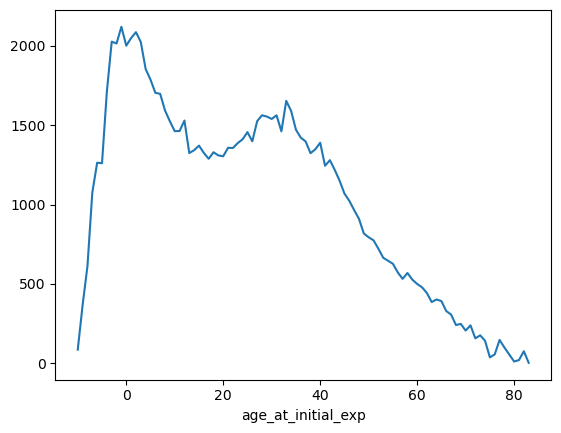

In [7]:
delta_bw_97 = 2010 - 1997

county_data['age_in_97'] = county_data['AGE'] - delta_bw_97

# drop people born after 97
county_data = county_data[county_data['age_in_97'] >= 0].copy()


delta_bw_initial_exp = 2010 - county_data['initial_HH_exp']

county_data['age_at_initial_exp'] = county_data['AGE'] - delta_bw_initial_exp

county_data['age_at_initial_exp'].value_counts().sort_index().plot()

5. Identifying people who entered high school with and without Hip Hop

In [8]:
# Let's look at people 6 years before and 6 years after the cutoff
age_cutoff = 13
cutoff_range = 6
mask = (county_data['age_at_initial_exp'] >= age_cutoff - cutoff_range) & (county_data['age_at_initial_exp'] <= age_cutoff + cutoff_range)
county_data = county_data[mask].copy()
county_data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,COUNTYFIP,STRATA,GQ,...,weighted_ave_non_HH_conc,weighted_sum_HH_conc,weighted_sum_non_HH_conc,non_weighted_ave_HH_conc,non_weighted_ave_non_HH_conc,non_weighted_sum_HH_conc,non_weighted_sum_non_HH_conc,initial_HH_exp,age_in_97,age_at_initial_exp
34,2010,201001,31.0,1658.0,112.0,2010000000311,1.0,55.0,100001,1,...,NaN,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,14.0,10.0
148,2010,201001,182.0,11433.0,69.0,2010000001821,1.0,55.0,100001,1,...,NaN,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,22.0,18.0
287,2010,201001,339.0,21387.0,128.0,2010000003391,1.0,55.0,100001,1,...,NaN,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,15.0,11.0
460,2010,201001,550.0,35338.0,73.0,2010000005501,1.0,55.0,100001,1,...,NaN,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,22.0,18.0
461,2010,201001,550.0,35338.0,73.0,2010000005501,1.0,55.0,100001,1,...,NaN,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,22.0,18.0


In [9]:
county_data['after_8th_grade'] = (county_data['age_in_97'] >= age_cutoff).astype(int)

In [10]:
county_data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,COUNTYFIP,STRATA,GQ,...,weighted_sum_HH_conc,weighted_sum_non_HH_conc,non_weighted_ave_HH_conc,non_weighted_ave_non_HH_conc,non_weighted_sum_HH_conc,non_weighted_sum_non_HH_conc,initial_HH_exp,age_in_97,age_at_initial_exp,after_8th_grade
34,2010,201001,31.0,1658.0,112.0,2010000000311,1.0,55.0,100001,1,...,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,14.0,10.0,1
148,2010,201001,182.0,11433.0,69.0,2010000001821,1.0,55.0,100001,1,...,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,22.0,18.0,1
287,2010,201001,339.0,21387.0,128.0,2010000003391,1.0,55.0,100001,1,...,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,15.0,11.0,1
460,2010,201001,550.0,35338.0,73.0,2010000005501,1.0,55.0,100001,1,...,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,22.0,18.0,1
461,2010,201001,550.0,35338.0,73.0,2010000005501,1.0,55.0,100001,1,...,NaN,NaN,0.0,1.0,0.0,187.0,1993.0,22.0,18.0,1


In [11]:
county_data.after_8th_grade.value_counts()

after_8th_grade
1    15573
0     2995
Name: count, dtype: int64

***Regressing***

In [12]:
outcome_var = 'INCTOT'

outcome_and_control_cols = [
    'SEX', 'AGE', 'MARST', 'RACE', 'HISPAN',
    'EDUC', 'EMPSTAT',
    'INCTOT'
]

dummy_cols = ['after_8th_grade']

county_data['FIPS'] = county_data['STATEFP']*10000 + county_data['COUNTYFP']

# Select only the necessary columns: dependent_var, control_cols, and hip_hop_var
hip_hop_var = 'non_weighted_ave_HH_conc'
required_cols = outcome_and_control_cols + [hip_hop_var] + dummy_cols + ['FIPS']
print(f'rows dropped: {county_data[required_cols].isna().any(axis=1).mean():.2%}')
data_subset = county_data[required_cols].dropna()

data_subset['exp_X_dummy'] = data_subset[hip_hop_var] * data_subset['after_8th_grade']

rows dropped: 6.26%


In [13]:
data_subset.head()

,SEX,AGE,MARST,RACE,HISPAN,EDUC,EMPSTAT,INCTOT,non_weighted_ave_HH_conc,after_8th_grade,FIPS,exp_X_dummy
34,2,27.0,6,1.0,0,6,3,2500.0,0.0,1,10055.0,0.0
148,2,35.0,4,1.0,0,10,1,66000.0,0.0,1,10055.0,0.0
287,2,28.0,4,2.0,0,6,1,35000.0,0.0,1,10055.0,0.0
460,1,35.0,1,1.0,0,11,1,49000.0,0.0,1,10055.0,0.0
461,2,35.0,1,1.0,0,10,1,20000.0,0.0,1,10055.0,0.0


In [15]:
import statsmodels.api as sm
import numpy as np

# Define the dependent variable (INCTOT)
data_subset['log_INCTOT'] = np.log(data_subset['INCTOT'])
y = data_subset['log_INCTOT']

# Define the independent variables (exp_X_dummy, controls, STATEFP, and COUNTYFP)
X = data_subset[['exp_X_dummy', 'SEX', 'AGE', 'MARST', 'RACE', 'HISPAN', 'EDUC', 'EMPSTAT', 'FIPS']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_INCTOT   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 23 Dec 2024   Prob (F-statistic):                nan
Time:                        16:17:54   Log-Likelihood:                    nan
No. Observations:               17405   AIC:                               nan
Df Residuals:                   17395   BIC:                               nan
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const              nan        nan        nan      

/opt/homebrew/Caskroom/miniforge/base/envs/station_env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/station_env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
